<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#PV-mismatch-loss-estimate-by-pvlib-python" data-toc-modified-id="PV-mismatch-loss-estimate-by-pvlib-python-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PV mismatch loss estimate by pvlib-python</a></span><ul class="toc-item"><li><span><a href="#Tools" data-toc-modified-id="Tools-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tools</a></span></li><li><span><a href="#Why-is-PV-mismatch-loss-important?" data-toc-modified-id="Why-is-PV-mismatch-loss-important?-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Why is PV mismatch loss important?</a></span></li><li><span><a href="#What-is-PV-array-mismatch-loss?" data-toc-modified-id="What-is-PV-array-mismatch-loss?-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>What is PV array mismatch loss?</a></span></li><li><span><a href="#Modeling-of-mismatch-loss-calculation-between-strings-in-partial-shade" data-toc-modified-id="Modeling-of-mismatch-loss-calculation-between-strings-in-partial-shade-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Modeling of mismatch loss calculation between strings in partial shade</a></span></li><li><span><a href="#Case-study" data-toc-modified-id="Case-study-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Case study</a></span><ul class="toc-item"><li><span><a href="#P-V-curve-of-PV-array-with-shade" data-toc-modified-id="P-V-curve-of-PV-array-with-shade-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>P-V curve of PV array with shade</a></span></li><li><span><a href="#Mismatch-losses-in-various-shade-condition" data-toc-modified-id="Mismatch-losses-in-various-shade-condition-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Mismatch losses in various shade condition</a></span></li></ul></li></ul></li></ul></div>

# PV mismatch loss estimate by pvlib-python
This is how to calculate mismatch loss between PV strings in solar power plant by using pvlib-python library.

---

## Tools

- Python 3.6
- pvlib-python(https://pvlib-python.readthedocs.io/en/latest/)

> PVLIB Python is a community supported tool that provides a set of functions and classes for simulating the performance of photovoltaic energy systems. PVLIB Python was originally ported from the PVLIB MATLAB toolbox developed at Sandia National Laboratories and it implements many of the models and methods developed at the Labs. More information on Sandia Labs PV performance modeling programs can be found at https://pvpmc.sandia.gov/. We collaborate with the PVLIB MATLAB project, but operate independently of it.

In [30]:
# scientific python add-ons
import numpy as np
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from itertools import product
from matplotlib.font_manager import FontProperties
#fp = FontProperties(fname='/System/Library/Fonts/Yu Gothic Bold.otf');
fp = FontProperties(fname='some.ttf', size=12);

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

# mport the pvlib library
import pvlib
from pvlib import pvsystem

## Why is PV mismatch loss important?

When a new solar power plant is constructed, it is very important to consider the project finance, for example, IRR or payback period. To evaluate these indices, solar power plant model software is used to simulate sun irradiance, temperature and solar plant model, and so on. In the simulation model, we need to consider various losses between photovoltic energy and energy production to the utility grid.
PV array mismatch loss is known as one of the losses. The loss is generally assumed 1% ~ 5%, so we should not ignore the loss factor.

## What is PV array mismatch loss?

The mismatch loss comes from the different I-V curve characteristics between all modules. The I-V curve for PV modules is manufactured to meet the design requirement and the I-V curve shape should be almost the same among the same type of PV modules. However, in real world, there should be a manufacturing error in the production. Not only this, there must be different environmental situation, such as uneven soiling, failure, cloud, shading by utility poll, building or grasses. In such a situation, not all the I-V curves are the same in solar power plants.

In solar power plants, PV modules (10~25 modules) are connected in series and make high DC voltage such as 600, 1000V. it is said "PV string". And PV strings are connected in paralell, it is said "PV array". PV array has one output and is connected to solar inverter (DC/AC).<br>
In the daytime, the solar energy goes to pv modules and the modules make currents and voltages. we see I-V curve charasteristics. We can understand the maximum power point is only one and it is decided to the voltage value.

In [2]:
def ivcurve_module(resistance_shunt, resistance_series, nNsVth, saturation_current, photocurrent):
    """
    From module parameter Rshunt, Rs, nNxVth, I0, Iphoto,
    return (voltage, current)
    """
    v_oc = pvsystem.v_from_i(resistance_shunt, resistance_series, nNsVth, 0, saturation_current, photocurrent)
    voltage = np.linspace(0, v_oc, 100)
    current = pvsystem.i_from_v(resistance_shunt, resistance_series, nNsVth, voltage, saturation_current, photocurrent)
    
    return voltage, current

In [3]:
# MODEL PARAMETERS
# SUNPOWER SPR-E20-327
resistance_shunt = 298.531
resistance_series = 0.36964
nNsVth = 0.026 * 96
saturation_current = 1.9162e-10
photocurrent = 6.468

In [4]:
voltage, current = ivcurve_module(resistance_shunt, resistance_series, nNsVth, saturation_current, photocurrent)
power = voltage * current # pv modules output DC voltage and current

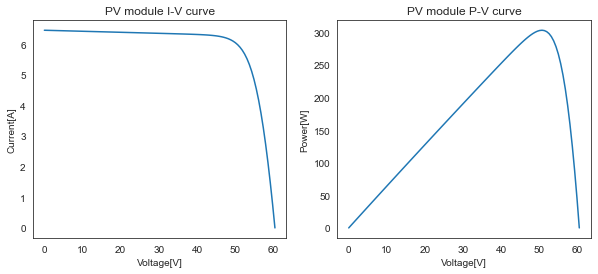

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(voltage, current)
axes[0].set_title("PV module I-V curve")
axes[0].set_ylabel("Current[A]")
axes[0].set_xlabel("Voltage[V]")

axes[1].plot(voltage, power)
axes[1].set_title("PV module P-V curve")
axes[1].set_ylabel("Power[W]")
axes[1].set_xlabel("Voltage[V]")

plt.show()

When the modules are connected each other in the array, each modlue's voltage and current is determined under the following conditions. 
- In a string, the modules are connected in series, so pv moudule currents in the same string are the same. 
- In a array, the strings are connected in paralell, the strings voltages are the same.
<br>

This means  : 
<br>
If the I-V curves shapes of all modules are the same, the total power of the array is the summation of the maximum power points of all modules. However, if there are differrences between I-V curves, not all modules can operate each maximum power point because of the above condition. Therefore the total power of the array is less than the summation of the maximum power points of all modules. This power difference is called mismatch loss.

Mismatch Loss $  = ( P_{max} - P_{array} ) / P_{array} $

$ P_{max} $ : Summation of maximum power of each module

$ P_{array} $ : Maximum power of array

## Modeling of mismatch loss calculation between strings in partial shade

In [6]:
def ivcurve_array_with_mismatch(resistance_shunt=None, 
                  resistance_series=None, 
                  nNsVth=None, 
                  saturation_current=None, 
                  photocurrent=None,
                  n_series=10, 
                  n_paralell=100, 
                  shade_ratio_s=0.1, 
                  shade_ratio_p=0.1, 
                  shade=0.1):
    """
    This is the calculation to output mismatch loss of the array.
    # MODEL PARAMETERS
    # DEFAULT SUNPOWER SPR-E20-327
    # n_series : the number of modules in a string.
    # n_paralell : the number of strings in a array.
    # shade_ratio_s : how much ratio of modules in a string are shaded.
    # shade_ratio_p : how much ratio of strings in a array are shaded.
    # shade : how much ratio of irradiance on shaded modules compared to non-shade modules.
    """
    if resistance_shunt == None:
        resistance_shunt = 298.531
    
    if resistance_series == None:
        resistance_series = 0.36964
    
    if nNsVth == None:
        nNsVth = 0.026 * 96
    
    if saturation_current == None:
        saturation_current = 1.9162e-10
    
    if photocurrent == None:
        photocurrent = 6.468
        
    if shade_ratio_s == 0:
        if shade_ratio_p == 0:
            print("shade parameter is changed to 0.1 to prevent error.")
            shade = .1
    
    # return short current 短絡電流を求める v = 0
    i_s = pvsystem.i_from_v(resistance_shunt, resistance_series, nNsVth, 0, saturation_current, photocurrent)
    # モジュール（ストリング）電流のベース行列
    tmp_i = np.arange(0, i_s, 0.02) # 初期値幅0.02
    # モジュール電圧をゼロベクトルで初期化
    tmp_v, tmp_v_shade = np.zeros(tmp_i.shape[0]), np.zeros(tmp_i.shape[0])
    tmp_v[:] = pvsystem.v_from_i(resistance_shunt, resistance_series, nNsVth, tmp_i, saturation_current, photocurrent)
    tmp_v_dummy = pvsystem.v_from_i(resistance_shunt, resistance_series, nNsVth, tmp_i, saturation_current, photocurrent*shade)
    tmp_v_shade = tmp_v_dummy * (tmp_v_dummy > 1)
    
    # ストリング電圧の計算
    v_noshade = n_series * tmp_v 
    v_shade = n_series * (1 - shade_ratio_s) * tmp_v + n_series * shade_ratio_s * tmp_v_shade
    
    # ストリング開放電圧とストリング電圧のベース行列
    v_oc = np.max(v_noshade)
    v = np.arange(0, v_oc, 2) # 初期値幅2
    
    # ストリング電圧で補間
    i_noshade = np.array([InterpolatedUnivariateSpline(x = v_noshade[::-1], y = tmp_i[::-1], k=1, ext=1)(v)])
    i_shade = np.array([InterpolatedUnivariateSpline(x = v_shade[::-1], y = tmp_i[::-1], k=1, ext=1)(v)])
    
    # 影有り、無しのストリング電流行列
    i_noshade = i_noshade.reshape(v.shape[0])
    i_shade = i_shade.reshape(v.shape[0])
    
    i_array = i_noshade * n_paralell * (1 - shade_ratio_p) + i_shade * n_paralell * shade_ratio_p
    p_array = i_array * v
    p_noshade = i_noshade * v
    p_shade = i_shade * v

    p_mp_array = np.max(p_array)
    p_mp_strings = np.max(p_noshade) * n_paralell * (1 - shade_ratio_p) + np.max(p_shade) * n_paralell * shade_ratio_p
    mismatch_loss_strings = (p_mp_strings - p_mp_array) / p_mp_array

    return {'mismatch_loss':mismatch_loss_strings*100, 
            'v_array':v, 'i_array':i_array, 'p_array':p_array, 
            'v_noshade': v_noshade, 'i_noshade': i_noshade, 'p_noshade': p_noshade,
            'v_shade': v_shade, 'i_shade': i_shade, 'p_shade': p_shade}

In [22]:
def case_study_mismatch(series_shade_ratios=[0.1], paralell_shade_ratios=[0.1]):
    """
    This is for the calculation of mismatch losses in various series ratio and paralell ratio of shade.
    # series_shade_ratios : list of shade_ratios of modules in a string
    # paralell_shade_ratios : list of shade_ratios of strings in an array
    
    Return mismatch losses
    """
    
    mismatch = pd.DataFrame(columns = ["shade_irrad", "shade_series", "shade_paralell", "mismatch_loss"])
    
    ivcurve = pd.DataFrame()
    
    for i, shade_ratio in enumerate(list(product(series_shade_ratios, paralell_shade_ratios))):
        
        print("Case: (shade_series, shade_paralell)",  shade_ratio)
        print("0",  shade_ratio[0])
        print("1",  shade_ratio[1])
        try: 
            res = ivcurve_array_with_mismatch(shade_ratio_s=shade_ratio[0], 
                                    shade_ratio_p=shade_ratio[1], 
                                    shade=.1)
        
            res_mismatch = pd.Series([ .1, shade_ratio[0], shade_ratio[1], res['mismatch_loss']], index=["shade_irrad", "shade_series", "shade_paralell", "mismatch_loss"], name = i)
            mismatch = mismatch.append(res_mismatch)
        except:
            print("got here")
        
        index = pd.MultiIndex.from_product([[shade_ratio], ['v_array', 'i_array', 'p_array']], names=['(series_paralell)', 'measure'])
        ivcurve =ivcurve.append(pd.DataFrame([res['i_array'], res['v_array'], res['p_array']], index=index))
        
    return mismatch, ivcurve

## Case study

### P-V curve of PV array with shade

In [8]:
# アレイ構成及び影の割合を設定
n_series = 10 #直列数
n_paralell = 100 #並列数
shade_ratio_s = 0.3 #直列数に占める影の割合
shade_ratio_p = 0.2 #並列数に占める影の割合
shade = 0.1 #影部分の日射強度

In [9]:
res = ivcurve_array_with_mismatch(n_series=n_series, n_paralell=n_paralell, shade_ratio_s=shade_ratio_s, 
                            shade_ratio_p=shade_ratio_p, shade=shade)
res['mismatch_loss']

14.865019104251278

In [10]:
print("Maximum power of no-shade string : ")
print(res['v_array'][np.argmax(res['p_noshade'])])
print("")
print("Maximum power of shade string : ")
print(res['v_array'][np.argmax(res['p_shade'])])
print("")
print("Maximum power of array : ")
print(res['v_array'][np.argmax(res['p_array'])])

Maximum power of no-shade string : 
506.0

Maximum power of shade string : 
354.0

Maximum power of array : 
506.0


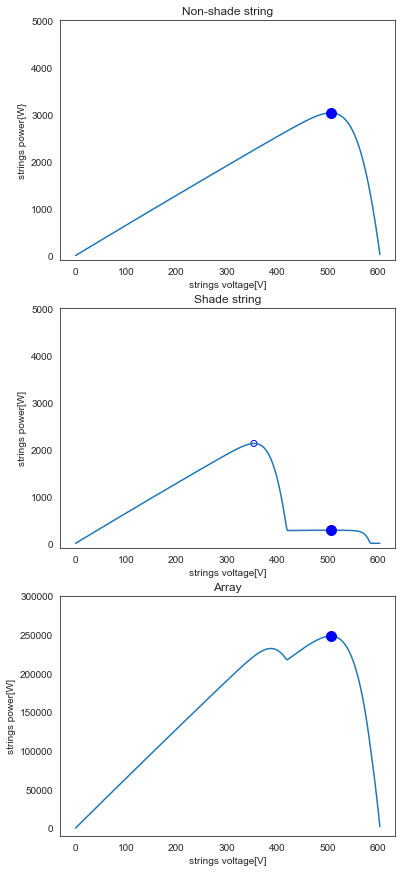

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(6, 15))
axs[0].plot(res['v_array'], res['p_noshade'])
axs[0].plot(res['v_array'][np.argmax(res['p_noshade'])], res['p_noshade'][np.argmax(res['p_noshade'])], 'bo', markersize=10)
axs[0].set_xlabel('strings voltage[V]')
axs[0].set_ylabel('strings power{W}')
axs[0].set_title('Non-shade string')
axs[0].set_ylim(-100, 5000)

axs[1].plot(res['v_array'], res['p_shade'])
axs[1].plot(res['v_array'][np.argmax(res['p_noshade'])], res['p_shade'][np.argmax(res['p_noshade'])], 'bo', markersize=10)
axs[1].scatter(res['v_array'][np.argmax(res['p_shade'])], res['p_shade'][np.argmax(res['p_shade'])], facecolors='none', edgecolors='b')
axs[1].set_xlabel('strings voltage[V]')
axs[1].set_ylabel('strings power[W]')
axs[1].set_title('Shade string')
axs[1].set_ylim(-100, 5000)

axs[2].plot(res['v_array'], res['p_array'])
axs[2].plot(res['v_array'][np.argmax(res['p_array'])], res['p_array'][np.argmax(res['p_array'])], 'bo', markersize=10)
axs[2].set_ylim(-10000, 300000)
axs[2].set_xlabel('strings voltage[V]')
axs[2].set_ylabel('strings power[W]')
axs[2].set_title('Array')

plt.savefig("./pv_curves.png")
plt.show()

### Mismatch losses in various shade condition

In [18]:
series_shade_ratios = [0.1*x for x in range(11)]
paralell_shade_ratios = [0.1*x for x in range(11)]

print(paralell_shade_ratios)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]


In [23]:
mismatch, ivcurve = case_study_mismatch(series_shade_ratios=series_shade_ratios, paralell_shade_ratios=paralell_shade_ratios)

Case: (shade_series, shade_paralell) (0.0, 0.0)
0 0.0
1 0.0
shade parameter is changed to 0.1 to prevent error.
Case: (shade_series, shade_paralell) (0.0, 0.1)
0 0.0
1 0.1
Case: (shade_series, shade_paralell) (0.0, 0.2)
0 0.0
1 0.2
Case: (shade_series, shade_paralell) (0.0, 0.30000000000000004)
0 0.0
1 0.30000000000000004
Case: (shade_series, shade_paralell) (0.0, 0.4)
0 0.0
1 0.4
Case: (shade_series, shade_paralell) (0.0, 0.5)
0 0.0
1 0.5
Case: (shade_series, shade_paralell) (0.0, 0.6000000000000001)
0 0.0
1 0.6000000000000001
Case: (shade_series, shade_paralell) (0.0, 0.7000000000000001)
0 0.0
1 0.7000000000000001
Case: (shade_series, shade_paralell) (0.0, 0.8)
0 0.0
1 0.8
Case: (shade_series, shade_paralell) (0.0, 0.9)
0 0.0
1 0.9
Case: (shade_series, shade_paralell) (0.0, 1.0)
0 0.0
1 1.0
Case: (shade_series, shade_paralell) (0.1, 0.0)
0 0.1
1 0.0
Case: (shade_series, shade_paralell) (0.1, 0.1)
0 0.1
1 0.1
Case: (shade_series, shade_paralell) (0.1, 0.2)
0 0.1
1 0.2
Case: (shade_ser

In [24]:
mismatch.shade_series = (mismatch.shade_series * 100).astype(int)
mismatch.shade_paralell = (mismatch.shade_paralell * 100).astype(int)

In [25]:
mismatch_pivot = mismatch.pivot( "shade_paralell", "shade_series", "mismatch_loss")

In [26]:
mismatch_pivot.round(2)

shade_series,0,10,20,30,40,50,60,70,80,90
shade_paralell,,,,,,,,,,
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10,0.0,1.56,7.69,6.69,5.64,4.58,3.51,2.45,1.41,0.37
20,0.0,2.32,10.35,14.87,12.54,10.18,7.81,5.46,3.13,0.83
30,0.0,2.61,10.31,21.60,21.18,17.20,13.21,9.23,5.29,1.39
40,0.0,2.63,9.58,19.45,32.30,26.25,20.17,14.11,8.08,2.11
50,0.0,2.45,8.44,16.79,28.04,38.35,29.50,20.66,11.84,3.05
60,0.0,2.13,7.04,13.80,22.90,35.67,42.65,29.90,17.14,4.36
70,0.0,1.71,5.46,10.59,17.47,27.14,41.70,43.94,25.20,6.30
80,0.0,1.20,3.74,7.19,11.82,18.32,28.13,44.46,38.88,9.46


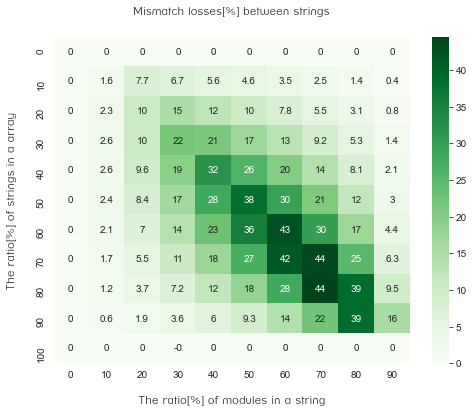

In [31]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(mismatch_pivot.round(1), annot=True, cmap="Greens")
ax.set_title("Mismatch losses[%] between strings", fontproperties = fp, x=0.5, y=1.05)
#ax.set_title(u'太陽光発電所における影の割合とストリング間のミスマッチ損失[%]', fontproperties = fp, x=0.5, y=1.05)
ax.set_xlabel("The ratio[%] of modules in a string", fontproperties = fp)
#ax.set_xlabel(u'ストリング中の影のかかるモジュール数の割合[%]', fontproperties = fp)
ax.set_ylabel("The ratio[%] of strings in a array", fontproperties = fp)
#ax.set_ylabel(u'影のかかるストリング数の割合[%]', fontproperties = fp)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.5)

plt.savefig("loss_heatmap.png")

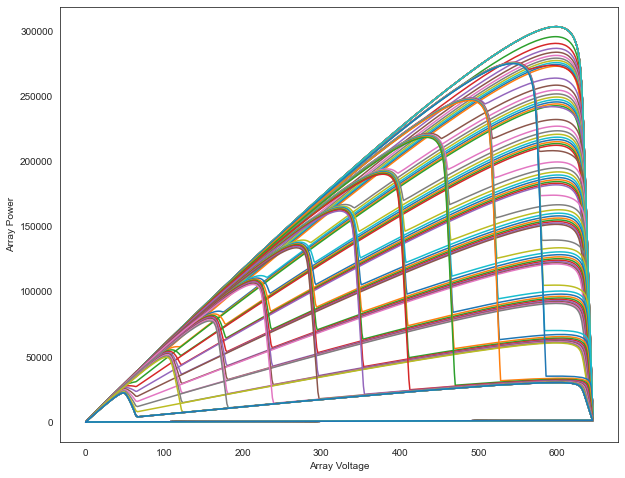

In [32]:
plt.figure(figsize=(10,8))
for idx in ivcurve.index.levels[0]:
    plt.plot(ivcurve.loc[idx].T.v_array, ivcurve.loc[idx].T.p_array)
plt.xlabel('Array Voltage')
plt.ylabel('Array Power')
plt.show()

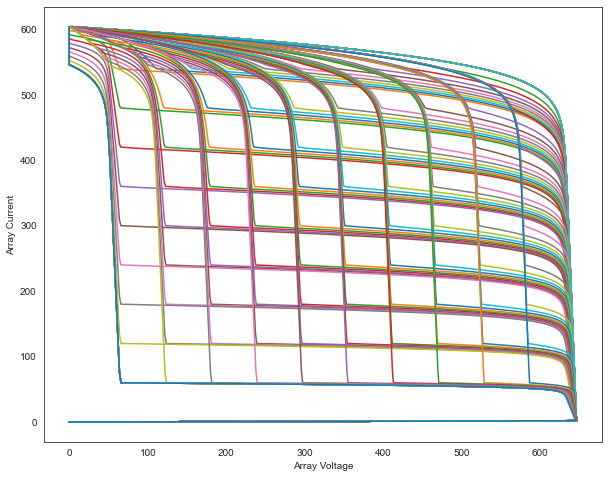

In [33]:
plt.figure(figsize=(10,8))
for idx in ivcurve.index.levels[0]:
    plt.plot(ivcurve.loc[idx].T.v_array, ivcurve.loc[idx].T.i_array)
plt.xlabel('Array Voltage')
plt.ylabel('Array Current')
plt.show()